# Machine Learning assignment 1

## Cloud Gaming

In this assignment we will take a closer look at datasets provided by a cloud gaming company.<br>
I decided to start with the Classification task

## Classification task

We start with importing "workhorse" modules

In [79]:
import pandas as pd
import numpy as np
import sklearn

import matplotlib.pyplot as plt
%matplotlib inline

# Visualizing 
import seaborn as sns

First, we need to read the data and check it's structure

In [104]:
stream_quality_df = pd.read_csv('./train_data.csv', low_memory=False)
stream_quality_test_df = pd.read_csv('./test_data.csv', low_memory=False)
stream_quality_df.head(5)

,fps_mean,fps_std,fps_lags,rtt_mean,rtt_std,dropped_frames_mean,dropped_frames_std,dropped_frames_max,auto_bitrate_state,auto_fec_state,auto_fec_mean,stream_quality
0,24.4,0.516398,0,91.1,6.723921,0.0,0.0,0.0,off,partial,50.0,0
1,28.6,2.065591,0,99.7,15.923777,0.0,0.0,0.0,off,partial,50.0,0
2,30.0,0.000000,0,98.1,11.798776,0.0,0.0,0.0,off,partial,50.0,0
3,30.3,0.948683,0,99.4,13.014522,0.0,0.0,0.0,off,partial,50.0,0
4,29.9,0.316228,0,123.2,62.476307,0.0,0.0,0.0,off,partial,50.0,0


From initial check we know that categorical features are present, let's get the whole pictureof our data types

In [81]:
types = stream_quality_df.dtypes
print("Number categorical featues:", sum(types=='object'))
print(types)

Number categorical featues: 2
fps_mean               float64
fps_std                float64
fps_lags                 int64
rtt_mean               float64
rtt_std                float64
dropped_frames_mean    float64
dropped_frames_std     float64
dropped_frames_max     float64
auto_bitrate_state      object
auto_fec_state          object
auto_fec_mean          float64
stream_quality           int64
dtype: object


Checking what profiling can tell us

In [ ]:
from pandas_profiling import ProfileReport

report = ProfileReport(stream_quality_df)
report.to_file('data_profile_report.html')

We need to encode our categorical features. <br>
For this I will use OneHotEncoder

In [98]:
from category_encoders import OneHotEncoder

cat_feats = stream_quality_df.select_dtypes(include=['object']).columns.tolist()
encoder = OneHotEncoder(cols=cat_feats, handle_unknown='ignore')

encoder.fit(stream_quality_df)

encoded_data = encoder.transform(stream_quality_df)
encoded_data.head(5)

/Users/nikitabogomazov/anaconda3/lib/python3.9/site-packages/category_encoders/one_hot.py:145: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for cat_name, class_ in values.iteritems():
/Users/nikitabogomazov/anaconda3/lib/python3.9/site-packages/category_encoders/one_hot.py:145: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for cat_name, class_ in values.iteritems():


,fps_mean,fps_std,fps_lags,rtt_mean,rtt_std,dropped_frames_mean,dropped_frames_std,dropped_frames_max,auto_bitrate_state_1,auto_bitrate_state_2,auto_bitrate_state_3,auto_fec_state_1,auto_fec_state_2,auto_fec_mean,stream_quality
0,24.4,0.516398,0,91.1,6.723921,0.0,0.0,0.0,1,0,0,1,0,50.0,0
1,28.6,2.065591,0,99.7,15.923777,0.0,0.0,0.0,1,0,0,1,0,50.0,0
2,30.0,0.000000,0,98.1,11.798776,0.0,0.0,0.0,1,0,0,1,0,50.0,0
3,30.3,0.948683,0,99.4,13.014522,0.0,0.0,0.0,1,0,0,1,0,50.0,0
4,29.9,0.316228,0,123.2,62.476307,0.0,0.0,0.0,1,0,0,1,0,50.0,0


Next step: get rid of outliers <br>
Before visualizing the data I tried both z-scores & IQR methods but to no avail <br>
(Looking ahead: z-scores method resullted in a significant drop in model accuracy and IQR got rid of almost all class 1 (stream_quality == 1) in the dataset)

After the statistical methods failed I went on with the visualization


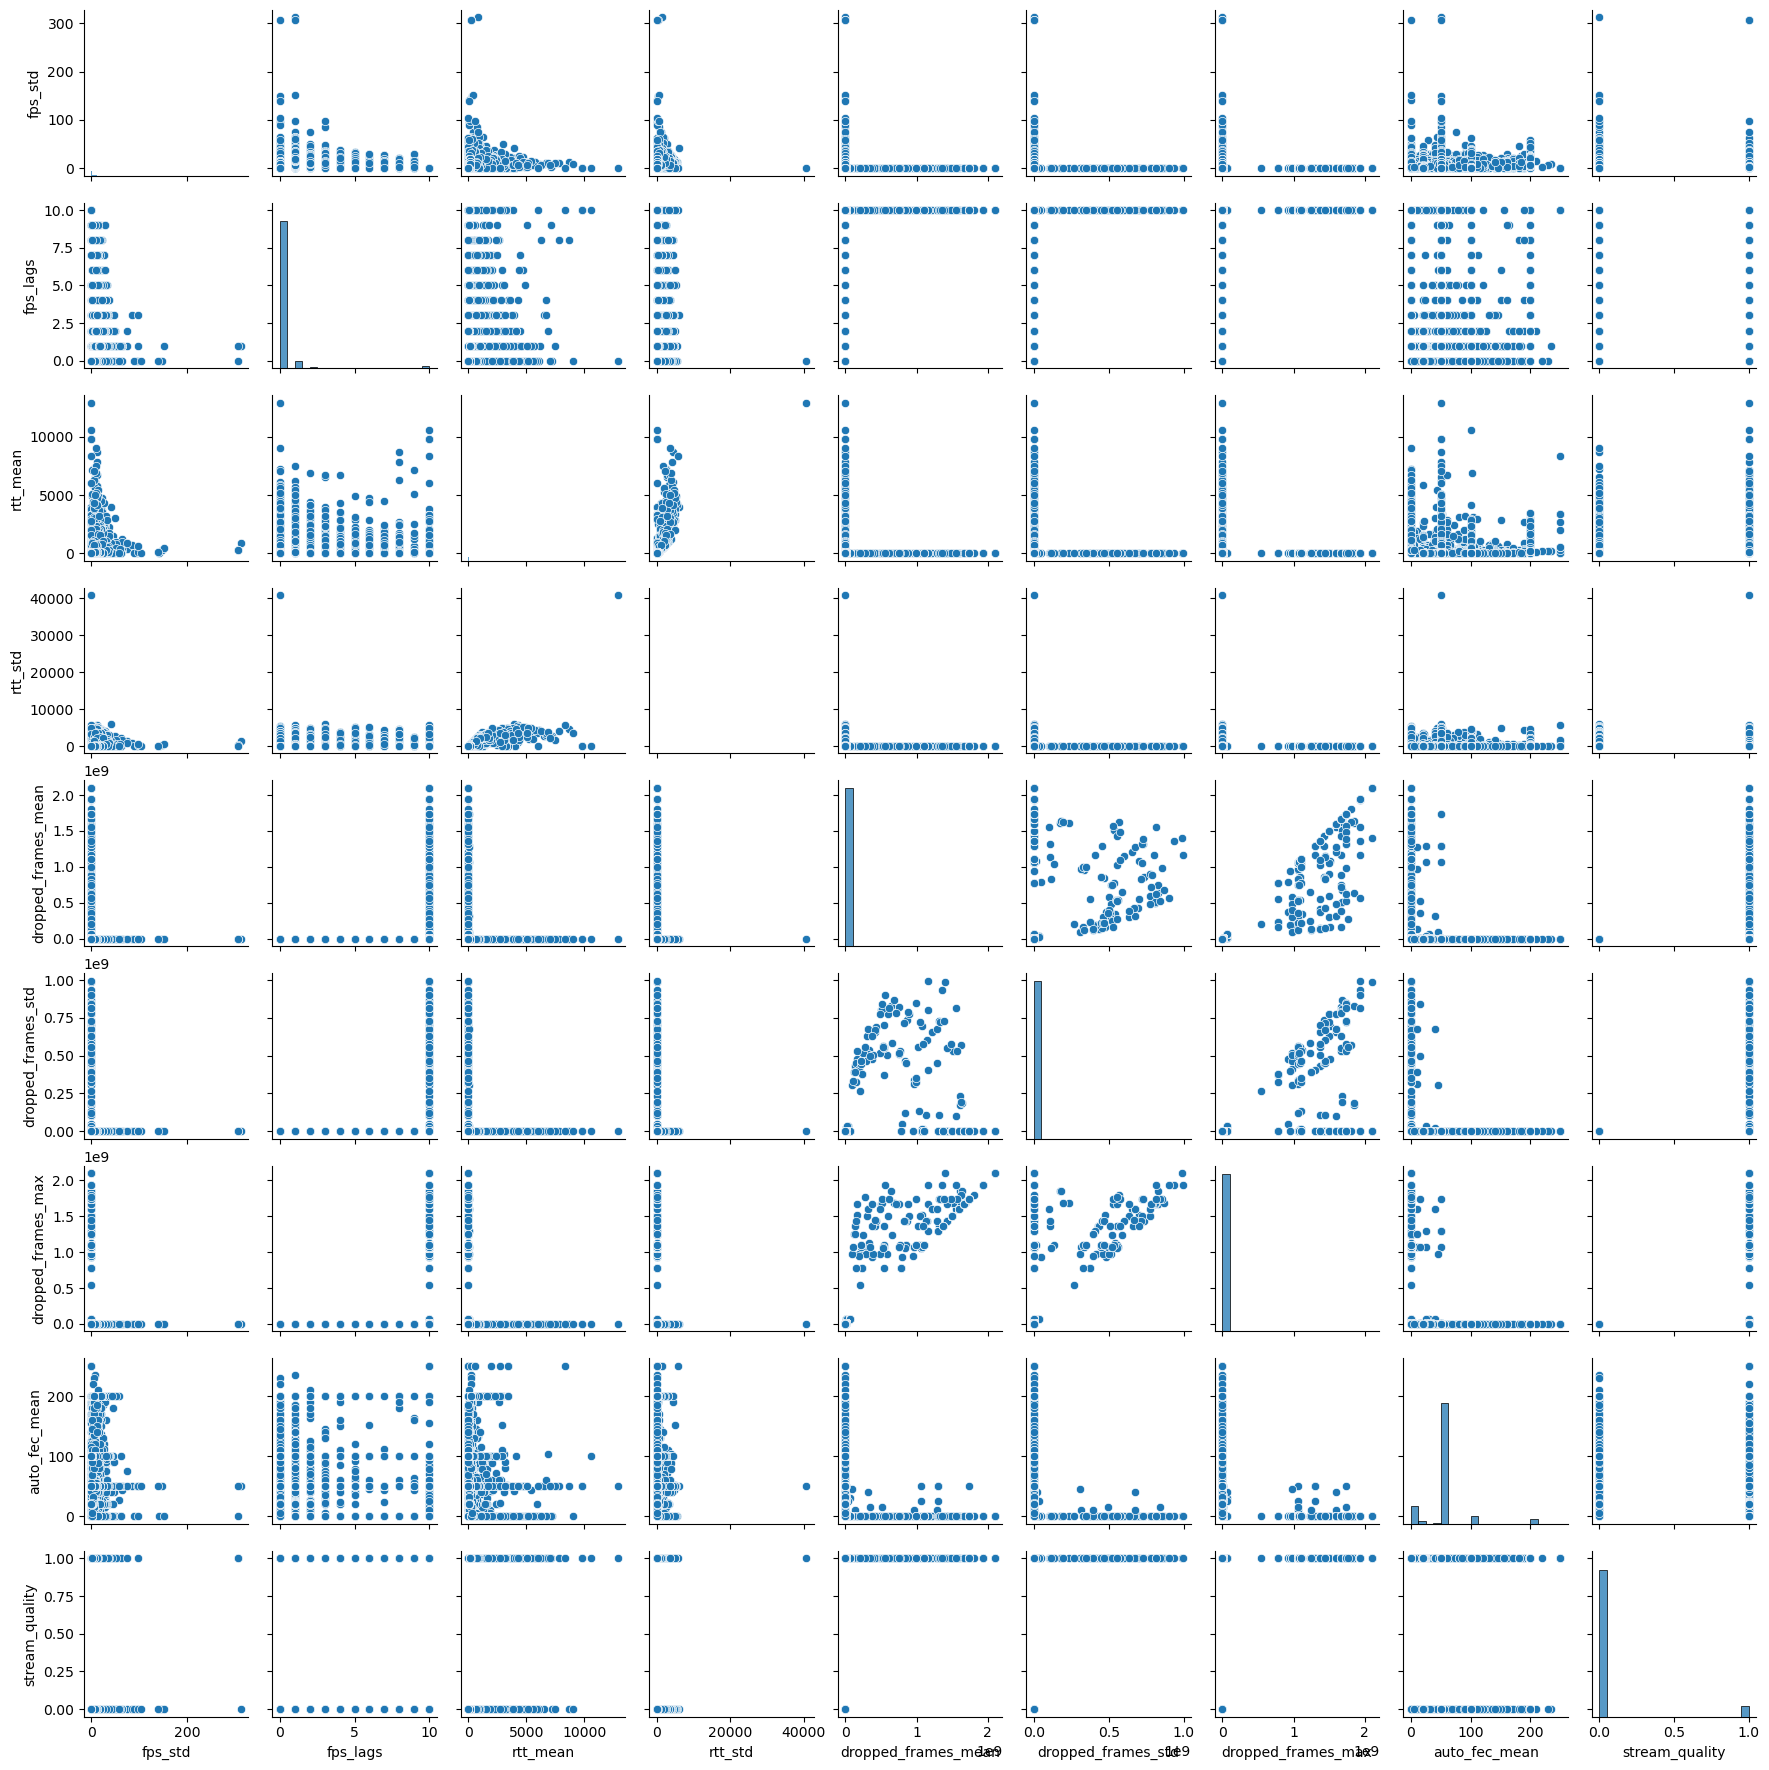

In [85]:
cols = stream_quality_df.columns[1:15]
sns.pairplot(stream_quality_df[cols], height=2.0)

That's a lot of plots, but bear with me <br>
After examining different subplots I decided to pay attention to these combinations: <br>
1) fps_mean / fps_std <br>
2) rtt_mean / rtt_std

After plotting them separately I decided to remove outliers by hand by drawing lines to separate the values

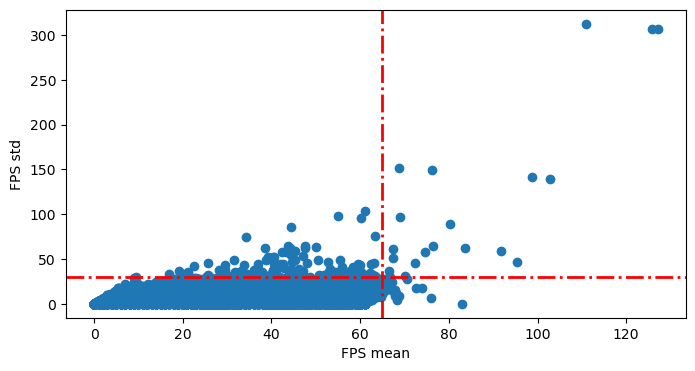

In [89]:
fig, ax = plt.subplots(figsize=(8,4))
ax.scatter(stream_quality_df['fps_mean'], stream_quality_df['fps_std'])
ax.set_xlabel('FPS mean')
ax.set_ylabel('FPS std')
plt.axhline(y=30, xmin=0, xmax=100, color='r', linestyle='-.', linewidth=2)
plt.axvline(x=65, ymin=0, ymax=100, color='r', linestyle='-.', linewidth=2)
plt.show()

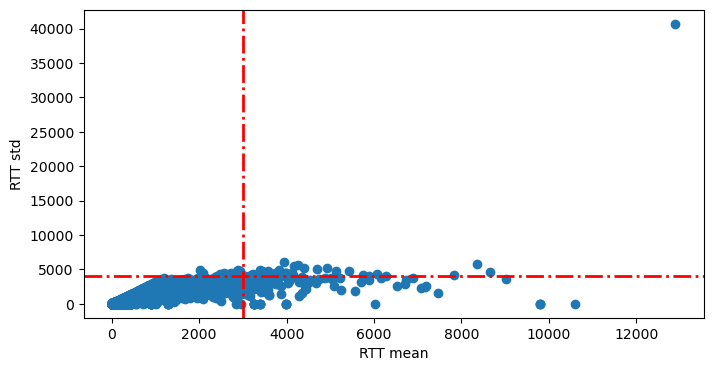

In [90]:
fig, ax = plt.subplots(figsize=(8,4))
ax.scatter(stream_quality_df['rtt_mean'], stream_quality_df['rtt_std'])
ax.set_xlabel('RTT mean')
ax.set_ylabel('RTT std')
plt.axhline(y=4000, xmin=0, xmax=100, color='r', linestyle='-.', linewidth=2)
plt.axvline(x=3000, ymin=0, ymax=100, color='r', linestyle='-.', linewidth=2)
plt.show()

Now I know which points are outliers, so I can move on to my preprocessing & feature engineering <br>
For this step I decided to add features based on occurence of outliers and dropped frames. <br>
Information about dropped frames is not that relevant, so I use it to detect dropped frames in general with 'dropped_frames_occured' feature <br>
After that I clear my outliers based on my investigation of the plots

In [99]:
# We don't need these
encoded_data.drop(["dropped_frames_std", 'dropped_frames_max'], inplace=True, axis=1)

# Features
encoded_data['dropped_frames_occured'] = encoded_data['dropped_frames_mean'].apply(lambda x: np.int8(x > 0))
encoded_data['fps_mean_out'] = encoded_data['fps_mean'].apply(lambda x: np.int8(x > 65))
encoded_data['fps_std_out'] = encoded_data['fps_std'].apply(lambda x: np.int8(x > 30))
encoded_data['rtt_mean_out'] = encoded_data['rtt_mean'].apply(lambda x: np.int8(x > 3000))
encoded_data['rtt_std_out'] = encoded_data['rtt_std'].apply(lambda x: np.int8(x > 4000))

# Used for feature creation, we don't need it anymore
encoded_data.drop(["dropped_frames_mean"], inplace=True, axis=1)

# Dropping outliers based on plots
encoded_data.drop(encoded_data[(encoded_data['fps_mean'] > 65)].index, inplace=True)
encoded_data.drop(encoded_data[(encoded_data['fps_std'] > 30)].index, inplace=True)
encoded_data.drop(encoded_data[(encoded_data['rtt_mean'] > 3000)].index, inplace=True)
encoded_data.drop(encoded_data[(encoded_data['rtt_std'] > 4000)].index, inplace=True)

Next step: do something with data imbalance.<br>
I decided to proceed with the down sampling approach:<br>
1) Calculate the count for each class <br>
2) Down sample the 'bad quality' class <br>
3) Create new data set by concatenating downsampled bad quality with good quality <br>
4) Check value counts of each class and visualize the resulting dataset

Number of good quality class: 27690
Number of bad quality class: 378550
Number of bad quality class after down sampling: 27690
0    27690
1    27690
Name: stream_quality, dtype: int64


<AxesSubplot: ylabel='Type'>

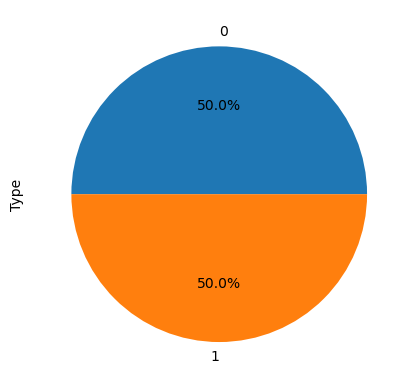

In [100]:
good_quality = encoded_data[encoded_data["stream_quality"] == 1]
bad_quality = encoded_data[encoded_data["stream_quality"] == 0]
print("Number of good quality class:", good_quality.shape[0])
print("Number of bad quality class:", bad_quality.shape[0])

from sklearn.utils import resample
bad_quality_downsample = resample(bad_quality, 
                                  replace=True,
                                  n_samples=len(good_quality),
                                  random_state=42)

print("Number of bad quality class after down sampling:", bad_quality_downsample.shape[0])


data_downsampled = pd.concat([bad_quality_downsample, good_quality])

print(data_downsampled["stream_quality"].value_counts())

data_downsampled.groupby('stream_quality').size().plot(kind='pie',
                                        y = "stream_quality",
                                        label = "Type",
                                        autopct='%1.1f%%')



Now we can finally train our model.

In [101]:
from sklearn.model_selection import train_test_split


x_train, x_test, y_train, y_test = train_test_split(data_downsampled.drop(['stream_quality'], axis=1), data_downsampled['stream_quality'], test_size=0.2,random_state=0)

For the classification task I decided to pick the LogisticRegression model <br>
To evaluate my model I use the accuracy/precision/recall metrics

In [102]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

clf = LogisticRegression(max_iter=1000, random_state=0).fit(x_train,y_train)
y_pred = clf.predict(x_test)

print(metrics.accuracy_score(y_test, y_pred))
print(metrics.precision_score(y_test, y_pred, average='weighted'))
print(metrics.recall_score(y_test, y_pred, average='weighted'))

0.736276634163958
0.7767074871690427
0.736276634163958


We got good results on training data, so it's time to check how the model will perform on test data <br>
Before testing we have to preprocess the test datasets almost the same as we did for training

In [105]:
cat_feats = stream_quality_test_df.select_dtypes(include=['object']).columns.tolist()
encoder = OneHotEncoder(cols=cat_feats, handle_unknown='ignore')


encoder.fit(stream_quality_test_df)

encoded_data = encoder.transform(stream_quality_test_df)


encoded_data.drop(["dropped_frames_std", 'dropped_frames_max'], inplace=True, axis=1)
encoded_data['dropped_frames_occured'] = encoded_data['dropped_frames_mean'].apply(lambda x: np.int8(x>0))
encoded_data['fps_mean_out'] = encoded_data['fps_mean'].apply(lambda x: np.int8(x > 65))
encoded_data['fps_std_out'] = encoded_data['fps_std'].apply(lambda x: np.int8(x > 30))
encoded_data['rtt_mean_out'] = encoded_data['rtt_mean'].apply(lambda x: np.int8(x > 3000))
encoded_data['rtt_std_out'] = encoded_data['rtt_std'].apply(lambda x: np.int8(x > 4000))
encoded_data.drop(["dropped_frames_mean"], inplace=True, axis=1)

X = encoded_data.drop(['stream_quality'],axis=1)
y = encoded_data['stream_quality']

y_pred = clf.predict(X)

print('Accuracy: ', metrics.accuracy_score(y, y_pred))
print('Precision: ', metrics.precision_score(y, y_pred, average='weighted'))
print('Recall: ', metrics.recall_score(y, y_pred, average='weighted'))

/Users/nikitabogomazov/anaconda3/lib/python3.9/site-packages/category_encoders/one_hot.py:145: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for cat_name, class_ in values.iteritems():
/Users/nikitabogomazov/anaconda3/lib/python3.9/site-packages/category_encoders/one_hot.py:145: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for cat_name, class_ in values.iteritems():


Accuracy:  0.8953225832936501
Precision:  0.9221989304035415
Recall:  0.8953225832936501


We got even better results on the testing data! It means that our model was able to generalize and didn't overfit during training

## Regression task

In this task we have to predict the bitrate of a game session. <br>
Before jumping to model training we have to do initial exploration and preprocessing

In [106]:
bitrate_df = pd.read_csv('./bitrate_train.csv', low_memory=False)
bitrate_df_test = pd.read_csv('./bitrate_test.csv', low_memory=False)

Checking if we have to deal with categorical features:

In [107]:
types = bitrate_df.dtypes
print("Number categorical featues:", sum(types=='object'))
print(types)

Number categorical featues: 0
fps_mean               float64
fps_std                float64
rtt_mean               float64
rtt_std                float64
dropped_frames_mean    float64
dropped_frames_std     float64
dropped_frames_max     float64
bitrate_mean           float64
bitrate_std            float64
target                 float64
dtype: object


No categorical features are present, so we don't need encoding and we can continue

In [153]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.preprocessing import PolynomialFeatures

from sklearn import metrics

In [154]:
bitrate_df.head(5)

,fps_mean,fps_std,rtt_mean,rtt_std,dropped_frames_mean,dropped_frames_std,dropped_frames_max,bitrate_mean,bitrate_std,target,dropped_frames_occured,fps_mean_out,fps_std_out,rtt_mean_out,rtt_std_out
0,24.4,0.516398,91.1,6.723921,0.0,0.0,0.0,460.5,7.648529,616.0,0,0,0,0,0
1,28.6,2.065591,99.7,15.923777,0.0,0.0,0.0,616.3,155.414893,565.0,0,0,0,0,0
2,30.0,0.000000,98.1,11.798776,0.0,0.0,0.0,565.2,9.077445,573.0,0,0,0,0,0
3,30.3,0.948683,99.4,13.014522,0.0,0.0,0.0,573.8,28.350191,585.0,0,0,0,0,0
4,29.9,0.316228,123.2,62.476307,0.0,0.0,0.0,585.8,59.458295,555.0,0,0,0,0,0


In [155]:
y = bitrate_df['target']
X = bitrate_df.drop(['target'], axis = 1)

Before doing anything I decided to check "baseline" models trained with no preprocessing. <br>
For this task I decided to use LinearRegression, Lasso, Ridge and Polynomial(2) Regression

In [156]:
X_train, X_test, y_train, y_test =  train_test_split(X, y, test_size=0.2)

In [157]:
regressor = LinearRegression()
regressor.fit(X_train, y_train)

lasso_reg = Lasso(alpha=0.5)
lasso_reg.fit(X_train, y_train)
ridge_reg = Ridge()
ridge_reg.fit(X_train, y_train)

poly_degree2 = 2
from sklearn.pipeline import make_pipeline
from sklearn import preprocessing

# Using scaler for polynomial regression
scaler = preprocessing.MinMaxScaler()


polyreg_scaled=make_pipeline(PolynomialFeatures(poly_degree2),scaler,LinearRegression())
polyreg_scaled.fit(X_train,y_train)

y_pred_poly_2 = polyreg_scaled.predict(X_test)
y_pred_lasso = lasso_reg.predict(X_test)
y_pred_ridge = ridge_reg.predict(X_test)
y_pred = regressor.predict(X_test)

In [159]:
print('LinearRegression:')
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

print('\nLasso:')
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred_lasso))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred_lasso))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred_lasso)))

print('\nRidge:')
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred_ridge))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred_ridge))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred_ridge)))

print('\nPolynomial (degree 2):')
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred_poly_2))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred_poly_2))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred_poly_2)))

LinearRegression:
Mean Absolute Error: 1102.6816634090576
Mean Squared Error: 3897591.1750790444
Root Mean Squared Error: 1974.231793655204

Lasso:
Mean Absolute Error: 1102.6749474409514
Mean Squared Error: 3897538.389092793
Root Mean Squared Error: 1974.2184248691412

Ridge:
Mean Absolute Error: 1102.68165118152
Mean Squared Error: 3897591.1272004456
Root Mean Squared Error: 1974.2317815293234

Polynomial (degree 2):
Mean Absolute Error: 1073.89735491135
Mean Squared Error: 3849962.5781279155
Root Mean Squared Error: 1962.1321510356827


After I got my baseline I decided to check pairplots as I did for the classification task:

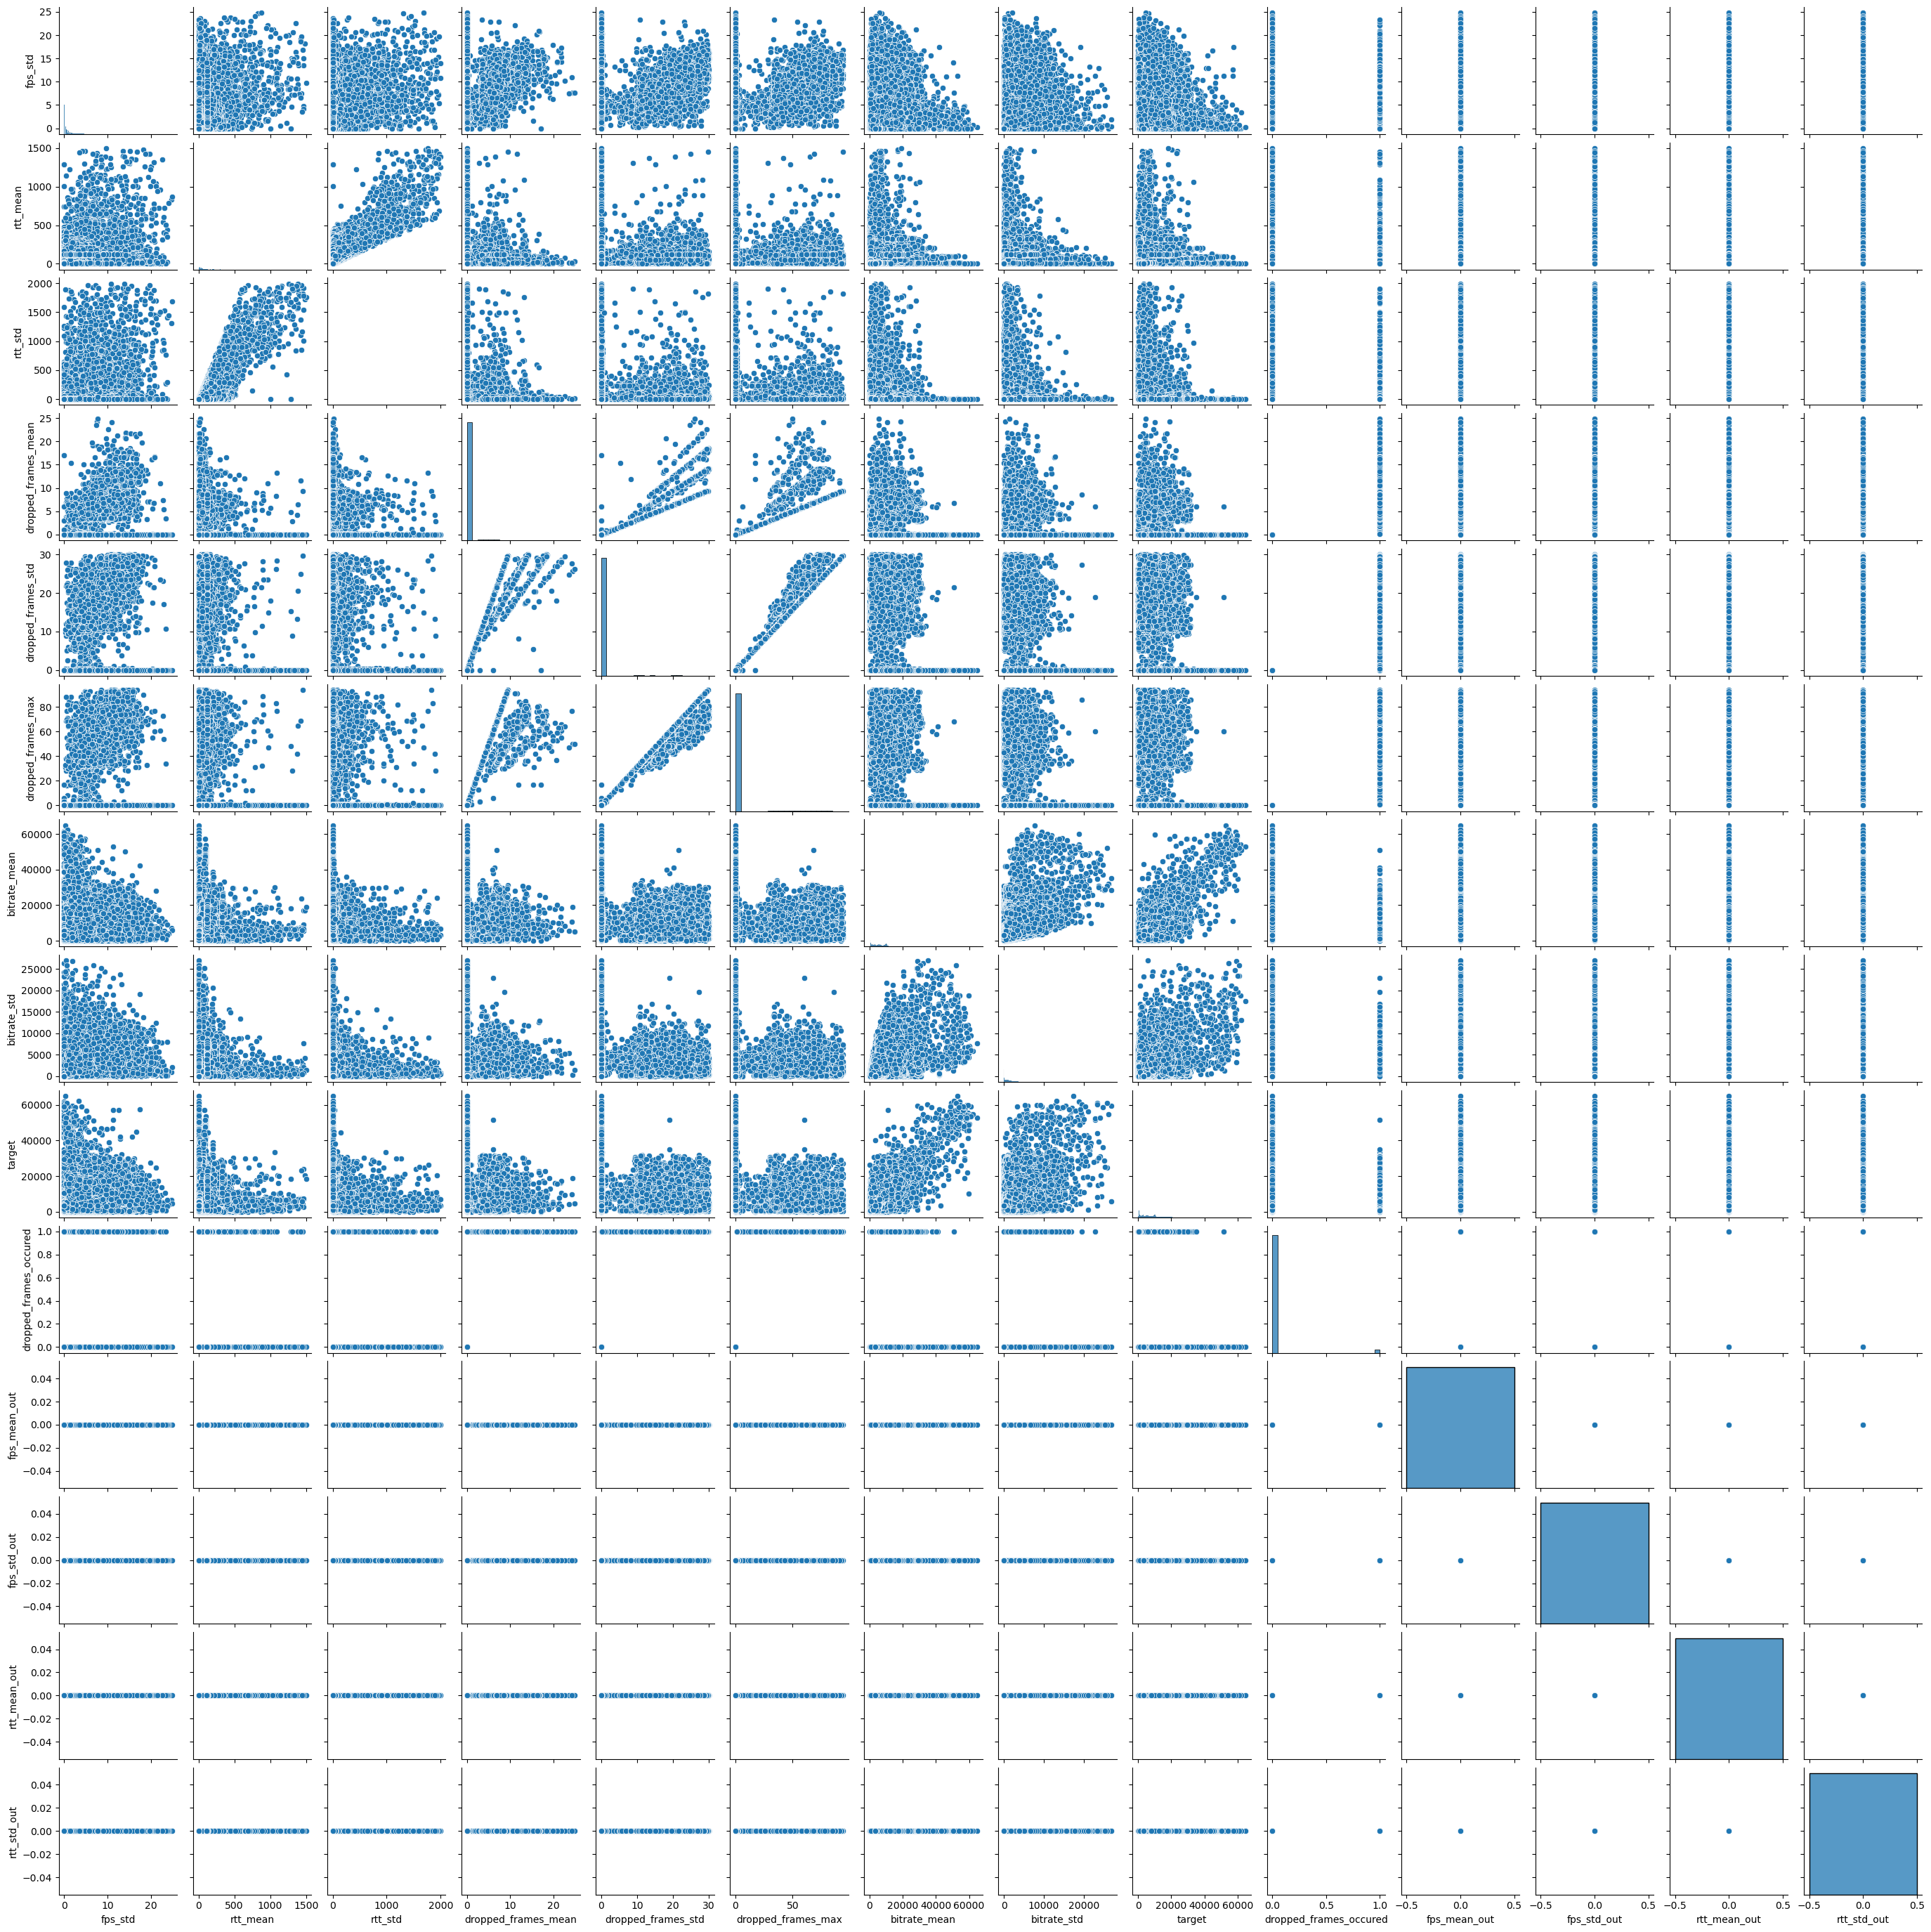

In [160]:
cols = bitrate_df.columns[1:15]
sns.pairplot(bitrate_df[cols], height=2.0)

After I got my plots it was time to filter outliers using the same approach as for classification task

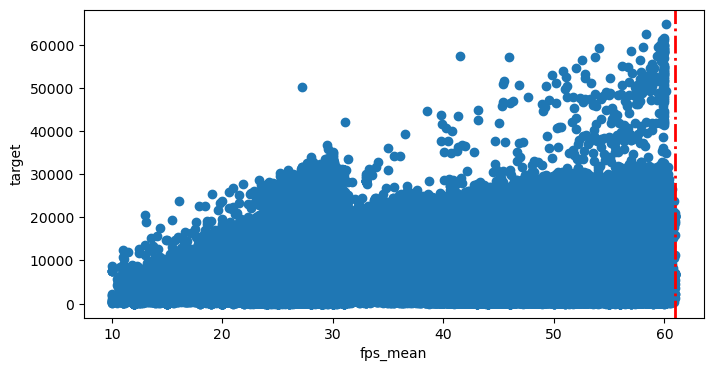

In [161]:
fig, ax = plt.subplots(figsize=(8,4))
ax.scatter(bitrate_df['fps_mean'], bitrate_df['target'])
ax.set_xlabel('fps_mean')
ax.set_ylabel('target')
# plt.axhline(y=4000, xmin=0, xmax=100, color='r', linestyle='-.', linewidth=2)
plt.axvline(x=61, ymin=0, ymax=100, color='r', linestyle='-.', linewidth=2)
plt.show()

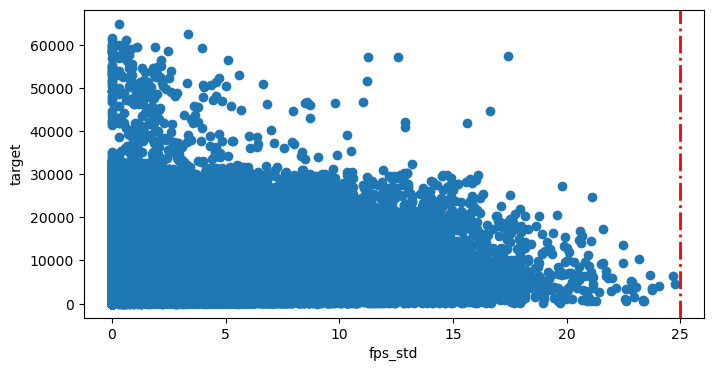

In [162]:
fig, ax = plt.subplots(figsize=(8,4))
ax.scatter(bitrate_df['fps_std'], bitrate_df['target'])
ax.set_xlabel('fps_std')
ax.set_ylabel('target')
# plt.axhline(y=4000, xmin=0, xmax=100, color='r', linestyle='-.', linewidth=2)
plt.axvline(x=25, ymin=0, ymax=100, color='r', linestyle='-.', linewidth=2)
plt.show()

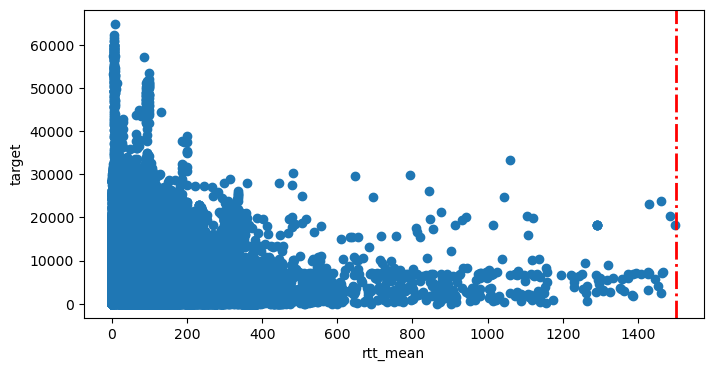

In [163]:
fig, ax = plt.subplots(figsize=(8,4))
ax.scatter(bitrate_df['rtt_mean'], bitrate_df['target'])
ax.set_xlabel('rtt_mean')
ax.set_ylabel('target')
plt.axvline(x=1500, ymin=0, ymax=100, color='r', linestyle='-.', linewidth=2)
plt.show()

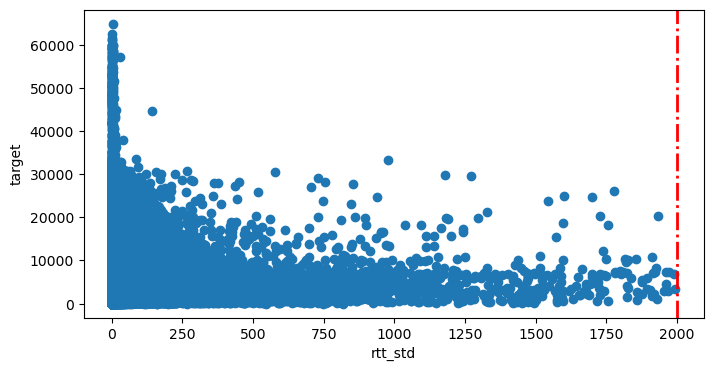

In [164]:
fig, ax = plt.subplots(figsize=(8,4))
ax.scatter(bitrate_df['rtt_std'], bitrate_df['target'])
ax.set_xlabel('rtt_std')
ax.set_ylabel('target')
# plt.axhline(y=4000, xmin=0, xmax=100, color='r', linestyle='-.', linewidth=2)
plt.axvline(x=2000, ymin=0, ymax=100, color='r', linestyle='-.', linewidth=2)
plt.show()

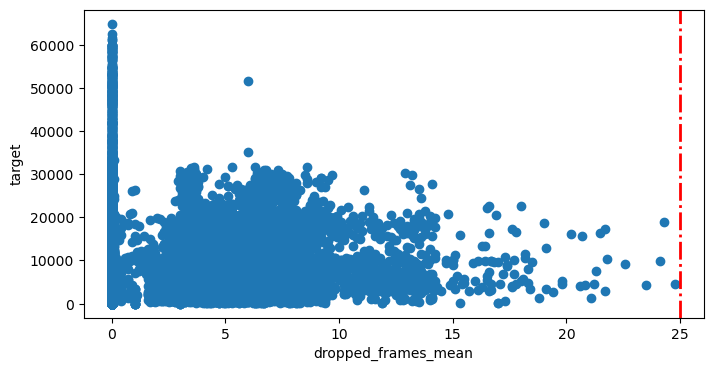

In [165]:
fig, ax = plt.subplots(figsize=(8,4))
ax.scatter(bitrate_df['dropped_frames_mean'], bitrate_df['target'])
ax.set_xlabel('dropped_frames_mean')
ax.set_ylabel('target')
# plt.axhline(y=4000, xmin=0, xmax=100, color='r', linestyle='-.', linewidth=2)
plt.axvline(x=25, ymin=0, ymax=100, color='r', linestyle='-.', linewidth=2)
plt.show()

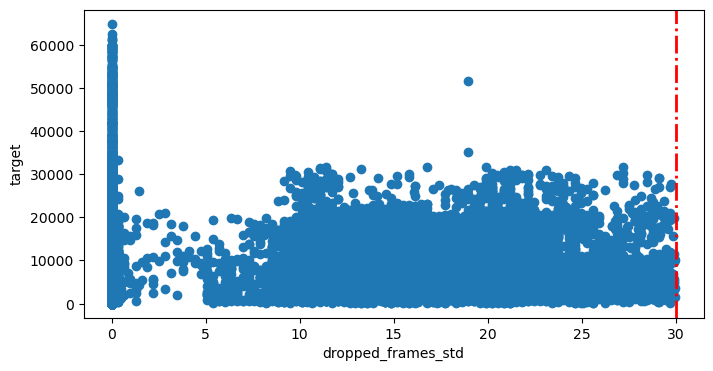

In [166]:
fig, ax = plt.subplots(figsize=(8,4))
ax.scatter(bitrate_df['dropped_frames_std'], bitrate_df['target'])
ax.set_xlabel('dropped_frames_std')
ax.set_ylabel('target')
plt.axvline(x=30, ymin=0, ymax=100, color='r', linestyle='-.', linewidth=2)

plt.show()

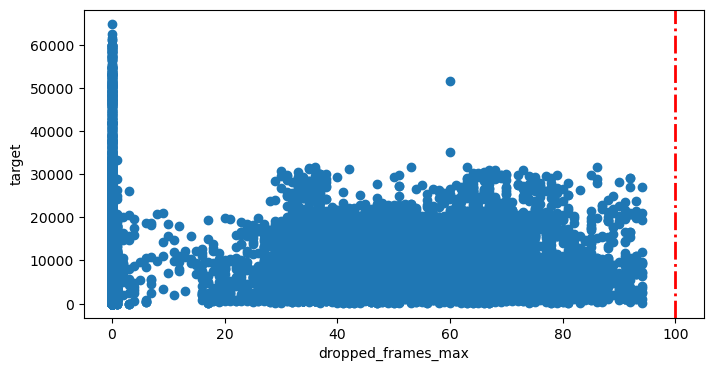

In [167]:
fig, ax = plt.subplots(figsize=(8,4))
ax.scatter(bitrate_df['dropped_frames_max'], bitrate_df['target'])
ax.set_xlabel('dropped_frames_max')
ax.set_ylabel('target')
# plt.axhline(y=4000, xmin=0, xmax=100, color='r', linestyle='-.', linewidth=2)
plt.axvline(x=100, ymin=0, ymax=100, color='r', linestyle='-.', linewidth=2)
plt.show()

After I got an idea how to filter my dataset it was time to do preprocessing and another round of training

In [168]:
bitrate_df = pd.read_csv('./bitrate_train.csv', low_memory=False)

In [169]:
bitrate_df['dropped_frames_occured'] = bitrate_df['dropped_frames_mean'].apply(lambda x: np.int8(x>0))
bitrate_df['fps_mean_out'] = bitrate_df['fps_mean'].apply(lambda x: np.int8(x > 61))
bitrate_df['fps_std_out'] = bitrate_df['fps_std'].apply(lambda x: np.int8(x > 25))
bitrate_df['rtt_mean_out'] = bitrate_df['rtt_mean'].apply(lambda x: np.int8(x > 1500))
bitrate_df['rtt_std_out'] = bitrate_df['rtt_std'].apply(lambda x: np.int8(x > 2000))
bitrate_df.drop(bitrate_df[(bitrate_df['fps_mean'] > 61)].index, inplace=True)
bitrate_df.drop(bitrate_df[(bitrate_df['fps_std'] > 25)].index, inplace=True)
bitrate_df.drop(bitrate_df[(bitrate_df['rtt_mean'] > 1500)].index, inplace=True)
bitrate_df.drop(bitrate_df[(bitrate_df['rtt_std'] > 2000)].index, inplace=True)
bitrate_df.drop(bitrate_df[(bitrate_df['dropped_frames_mean'] > 25)].index, inplace=True)
bitrate_df.drop(bitrate_df[(bitrate_df['dropped_frames_std'] > 30)].index, inplace=True)
bitrate_df.drop(bitrate_df[(bitrate_df['dropped_frames_max'] > 100)].index, inplace=True)


In [170]:
y = bitrate_df['target']
X = bitrate_df.drop(['target'], axis = 1)

In [171]:
X_train, X_test, y_train, y_test =  train_test_split(X, y, test_size=0.2)

In [174]:
regressor = LinearRegression()
regressor.fit(X_train, y_train)

lasso_reg = Lasso(alpha=0.5)
lasso_reg.fit(X_train, y_train)
ridge_reg = Ridge()
ridge_reg.fit(X_train, y_train)

poly_degree2 = 2
from sklearn.pipeline import make_pipeline
from sklearn import preprocessing
scaler = preprocessing.StandardScaler()


polyreg_scaled=make_pipeline(PolynomialFeatures(poly_degree2),LinearRegression())
polyreg_scaled.fit(X_train,y_train)
y_pred_poly_2 = polyreg_scaled.predict(X_test)
y_pred_lasso = lasso_reg.predict(X_test)
y_pred_ridge = ridge_reg.predict(X_test)
y_pred = regressor.predict(X_test)


In [175]:
print('LinearRegression:')
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

print('\nLasso:')
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred_lasso))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred_lasso))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred_lasso)))

print('\nRidge:')
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred_ridge))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred_ridge))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred_ridge)))

print('\nPolynomial (degree 2):')
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred_poly_2))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred_poly_2))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred_poly_2)))

LinearRegression:
Mean Absolute Error: 1086.8353759828285
Mean Squared Error: 3816948.4735305444
Root Mean Squared Error: 1953.7012242230244

Lasso:
Mean Absolute Error: 1086.8059235316916
Mean Squared Error: 3816743.8822390256
Root Mean Squared Error: 1953.6488635983246

Ridge:
Mean Absolute Error: 1086.8353328609683
Mean Squared Error: 3816948.2195173963
Root Mean Squared Error: 1953.7011592148367

Polynomial (degree 2):
Mean Absolute Error: 1058.8377974486991
Mean Squared Error: 3778748.009114684
Root Mean Squared Error: 1943.9002055441745


We can see a slight decrease in RMS after filtering the outliers <br>
Now it's time to test our models on the test dataset

In [178]:
bitrate_df_test = pd.read_csv('./bitrate_test.csv', low_memory=False)

bitrate_df_test['dropped_frames_occured'] = bitrate_df_test['dropped_frames_mean'].apply(lambda x: np.int8(x > 0))
bitrate_df_test['fps_mean_out'] = bitrate_df_test['fps_mean'].apply(lambda x: np.int8(x > 61))
bitrate_df_test['fps_std_out'] = bitrate_df_test['fps_std'].apply(lambda x: np.int8(x > 25))
bitrate_df_test['rtt_mean_out'] = bitrate_df_test['rtt_mean'].apply(lambda x: np.int8(x > 1500))
bitrate_df_test['rtt_std_out'] = bitrate_df_test['rtt_std'].apply(lambda x: np.int8(x > 2000))


y = bitrate_df_test['target']
X = bitrate_df_test.drop(['target'], axis = 1)

y_pred = regressor.predict(X)
y_pred_poly_2 = polyreg_scaled.predict(X)
y_pred_lasso = lasso_reg.predict(X)
y_pred_ridge = ridge_reg.predict(X)

from sklearn.metrics import r2_score, mean_squared_error
print('LinearRegression r2 score: ', r2_score(y, y_pred))
print('Lasso r2 score: ', r2_score(y, y_pred_lasso))
print('Ridge r2 score: ', r2_score(y, y_pred_ridge))
print('Polynomial(2) r2 score: ', r2_score(y, y_pred_poly_2))

print('\nLinearRegression:')
print('Mean Absolute Error:', metrics.mean_absolute_error(y, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y, y_pred)))

print('\nLasso:')
print('Mean Absolute Error:', metrics.mean_absolute_error(y, y_pred_lasso))
print('Mean Squared Error:', metrics.mean_squared_error(y, y_pred_lasso))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y, y_pred_lasso)))

print('\nRidge:')
print('Mean Absolute Error:', metrics.mean_absolute_error(y, y_pred_ridge))
print('Mean Squared Error:', metrics.mean_squared_error(y, y_pred_ridge))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y, y_pred_ridge)))

print('\nPolynomial (degree 2):')
print('Mean Absolute Error:', metrics.mean_absolute_error(y, y_pred_poly_2))
print('Mean Squared Error:', metrics.mean_squared_error(y, y_pred_poly_2))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y, y_pred_poly_2)))

LinearRegression r2 score:  0.8934142881071756
Lasso r2 score:  0.8934448439319403
Ridge r2 score:  0.8934143369016263
Polynomial(2) r2 score:  0.8807207364941513

LinearRegression:
Mean Absolute Error: 1077.3140503245625
Mean Squared Error: 3800918.373900605
Root Mean Squared Error: 1949.5944126665436

Lasso:
Mean Absolute Error: 1076.9886669106518
Mean Squared Error: 3799828.732580812
Root Mean Squared Error: 1949.3149393006795

Ridge:
Mean Absolute Error: 1077.313715115274
Mean Squared Error: 3800916.6338575855
Root Mean Squared Error: 1949.593966408797

Polynomial (degree 2):
Mean Absolute Error: 1063.0098080020991
Mean Squared Error: 4253578.98571426
Root Mean Squared Error: 2062.4206616775004


Wow, r2 score of 0.89 means we've constructed a good model. As we see from r2 score comparisson between the models, Lasso got a tiny advantage over it's neighbours and everyone scored better than a Polynomial(2)